## Importing Libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import os

from tqdm import tqdm_notebook as tqdm
tqdm().pandas()

import matplotlib.pyplot as plt

from PIL import Image
from keras.datasets import fashion_mnist

from keras.models import Model
from keras.optimizers import Adam
from keras.layers import Dense, Input, Embedding
from keras.layers import Conv2D, Conv2DTranspose
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LeakyReLU
from keras.layers import Reshape
from keras.layers import Concatenate

from keras.utils.vis_utils import plot_model
from keras.models import load_model

|          | 0/? [00:00<?, ?it/s]

## Loading & Exploring dataset

In [2]:
(trainX, trainy), (testX, testy) = fashion_mnist.load_data()

4423680/4422102 [==============================] - 1s 0us/step


In [3]:
print('X - Shape', trainX.shape)

print('Y- Shape', trainy.shape)

print('Classes : ', np.unique(trainy))

X - Shape (60000, 28, 28)
Y- Shape (60000,)
Classes :  [0 1 2 3 4 5 6 7 8 9]


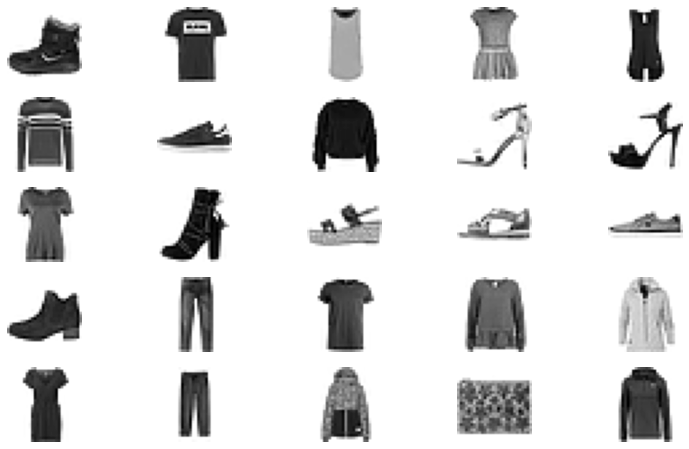

In [4]:
def plot_images(images, n):
    plt.figure(figsize=(13,8))
    for i in range(n * n):
        plt.subplot(n, n, i+1)
        plt.axis('off')
        plt.imshow(images[i], cmap='gray_r')
    plt.show()

plot_images(trainX, 5)

## Define models

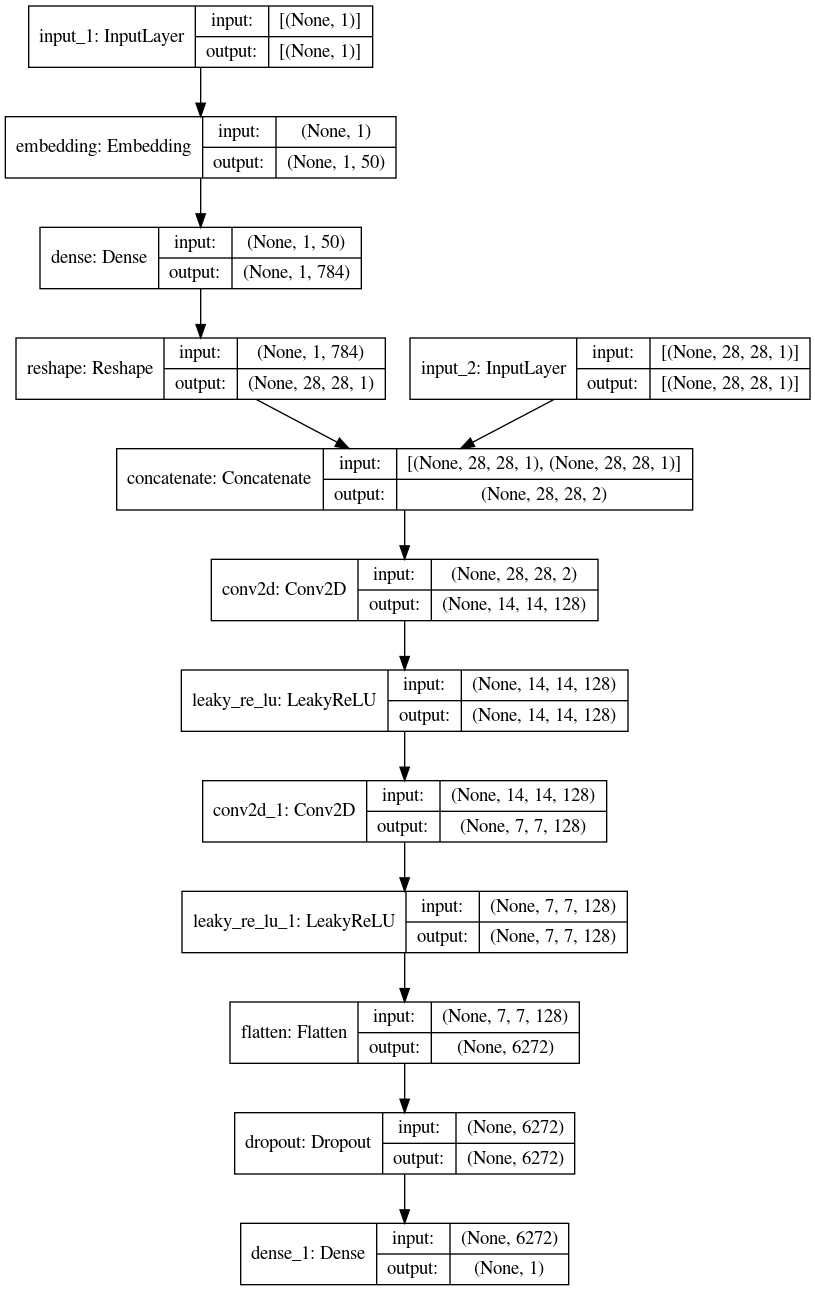

In [5]:
def define_discriminator(in_shape=(28,28,1), n_classes=10):
    
    # Label Input
    in_label = Input(shape=(1,))    
    # embedding for categorical input
    li = Embedding(n_classes, 50)(in_label)
    # scale up to image dimensions with linear activation
    n_nodes = in_shape[0] * in_shape[1]
    
    li = Dense(n_nodes)(li)
    li = Reshape((in_shape[0], in_shape[1], 1))(li)
    
    
    # Image Input 28x28
    in_image = Input(shape=in_shape)
    merge = Concatenate()([in_image, li])
    
    # downsample 14x14
    fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(merge)
    fe = LeakyReLU(alpha=0.2)(fe)
    
    # downsample 7x7
    fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    
    #Flatten Feature maps
    fe = Flatten()(fe)
    fe = Dropout(0.4)(fe)
    
    out_layer = Dense(1, activation='sigmoid')(fe)
    
    model = Model([in_image, in_label], out_layer)
    
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model
    
    
discriminator = define_discriminator()
    
plot_model(discriminator, to_file='discriminator_plot.png', show_shapes=True, show_layer_names=True)

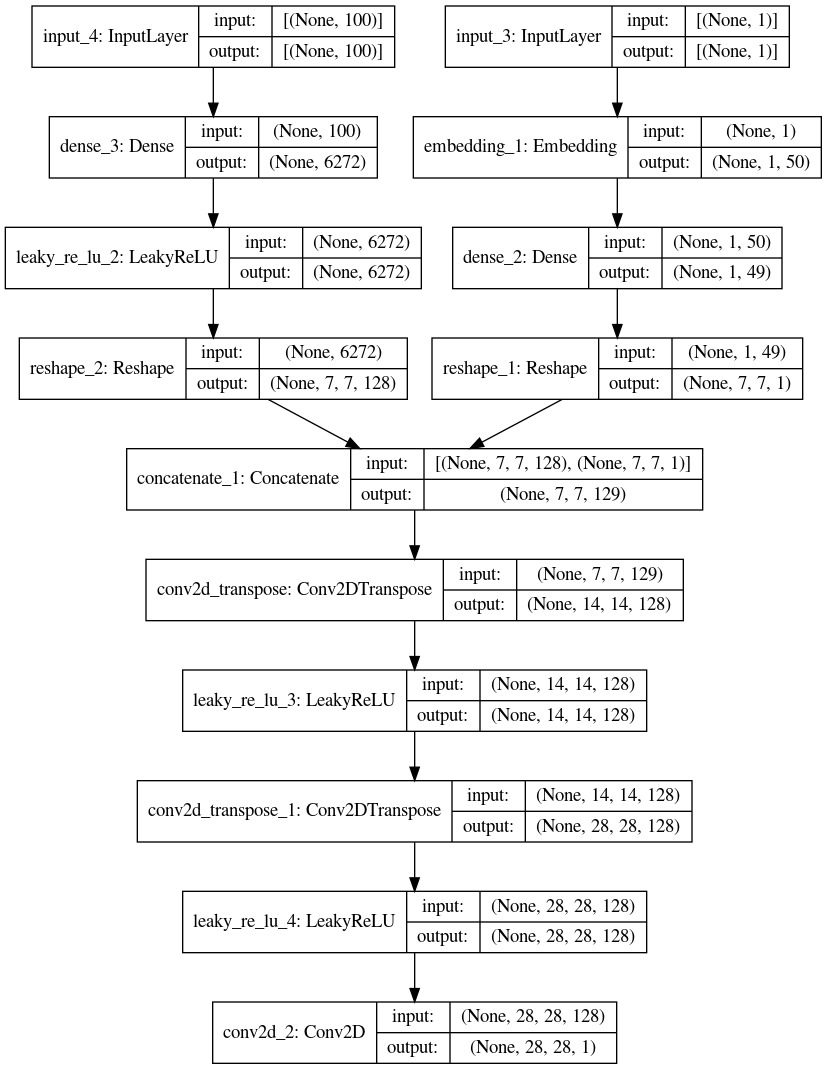

In [6]:
def define_generator(latent_dim, n_classes=10):
    
    # Label input
    in_label = Input(shape=(1,))
    
    li = Embedding(n_classes, 50)(in_label)
    
    n_nodes = 7 * 7
    li = Dense(n_nodes)(li)
    
    li = Reshape((7, 7, 1))(li)
    
    
    # Image generator input
    in_lat = Input(shape=(latent_dim,))
    # foundation for 7x7 image
    n_nodes = 128 * 7 * 7
    gen = Dense(n_nodes)(in_lat)
    gen = LeakyReLU(alpha=0.2)(gen)
    gen = Reshape((7, 7, 128))(gen)
    
    # merge image gen and label input
    merge = Concatenate()([gen, li])
    
    # upsample to 14x14
    gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(merge) 
    gen = LeakyReLU(alpha=0.2)(gen)
    
    # upsample to 28x28
    gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(gen) 
    gen = LeakyReLU(alpha=0.2)(gen)
    
    
    out_layer = Conv2D(1, (7,7), activation='tanh', padding='same')(gen)
    
    model = Model([in_lat, in_label], out_layer)
    return model

latent_dim = 100

generator = define_generator(latent_dim)

plot_model(generator, to_file='generator_plot.png', show_shapes=True, show_layer_names=True)


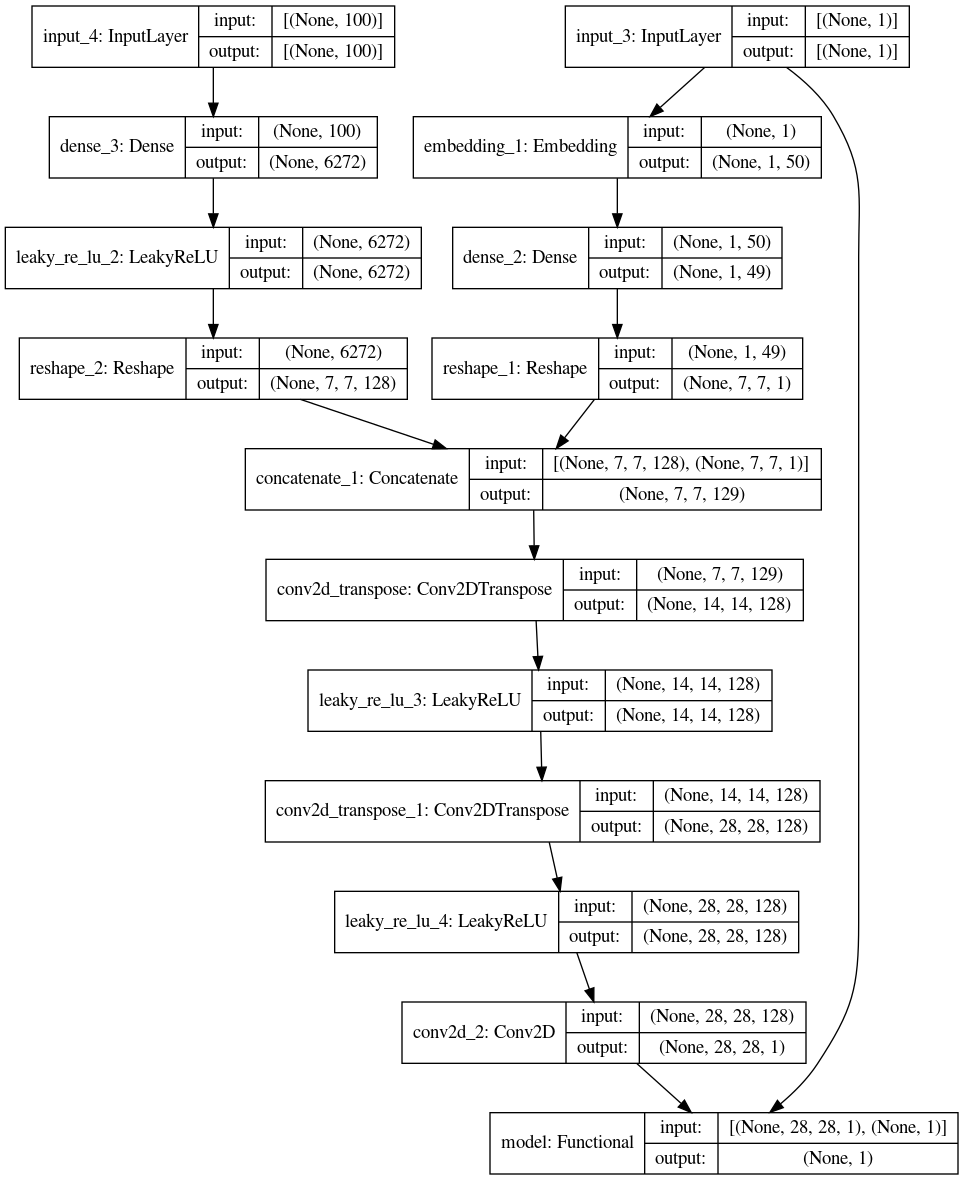

In [7]:
# define the combined generator and discriminator model, for updating the generator

def define_gan(generator, discriminator):
    discriminator.trainable = False
    
    gen_noise, gen_label = generator.input
    
    gen_output = generator.output
    
    
    # connect image output and label input from generator as inputs to discriminator
    gan_output = discriminator([gen_output, gen_label])
    
    model = Model([gen_noise, gen_label], gan_output)
    
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    
    return model

model = define_gan(generator, discriminator)

plot_model(model, to_file='gan_plot.png', show_shapes=True, show_layer_names=True)

## Generate Samples

In [8]:
print(trainX.shape)
print(np.expand_dims(trainX, axis=-1).shape)

(60000, 28, 28)
(60000, 28, 28, 1)


In [9]:
def load_real_samples():
    (trainX, trainy), (_, _) = fashion_mnist.load_data()
    
    X = np.expand_dims(trainX, axis=-1)
    
    X = X.astype('float32')
    X = (X - 127.5) / 127.5
    
    return [X, trainy]


def generate_real_samples(dataset, n_samples):
    images, labels = dataset
    ix = np.random.randint(0, images.shape[0], n_samples)
    
    X, labels = images[ix], labels[ix]
    
    y = np.ones((n_samples, 1))
    
    return [X, labels], y

In [10]:
def generate_latent_points(latent_dim, n_samples, n_classes=10):
    x_input = np.random.randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n_samples, latent_dim)
    
    labels = np.random.randint(0, n_classes, n_samples)
    return [x_input, labels]

def generate_fake_samples(generator, latent_dim, n_samples):
    x_input, labels = generate_latent_points(latent_dim, n_samples)
    images = generator.predict([x_input, labels])
    
    y = np.zeros((n_samples, 1))
    
    return [images, labels], y

In [11]:
def save_plot(examples, epoch, n=10):
  # plot images
    plt.figure(figsize=(10,5))
    for i in range(n * n):
        # define subplot
        plt.subplot(n, n, 1 + i)
        # turn off axis
        plt.axis('off')
        # plot raw pixel data
        plt.imshow(examples[i], cmap='gray_r')
        # save plot to file
    filename = 'generated_plot_e%03d.png' % (epoch+1) 
    plt.savefig(filename)
    plt.close()

def summarize_performance(epoch, generator, discriminator, dataset, latent_dim, n_samples=100):
    [X_real, labels_real], y_real = generate_real_samples(dataset, n_samples)
    _, acc_real = discriminator.evaluate([X_real, labels_real], y_real, verbose=0)
    
    [X_fake, labels], y_fake = generate_fake_samples(generator, latent_dim, n_samples)
    _, acc_fake = discriminator.evaluate([X_fake, labels], y_fake, verbose=0)

    print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
    
    save_plot(X_fake, epoch)
    
    # save model to file
    filename = 'generator_model_%03d.h5' % (epoch + 1)
    generator.save(filename)

- Chúng ta kỳ vọng rằng giá trị của accuracy trên cả real và fake giao động xung quanh giá trị 50%. Điều đó có nghĩa là gì? Chúng ta có khoảng 50% dữ liệu real được dự đoán nhầm thành fake và chúng ta có khoảng `50%` dữ liệu fake được dự đoán thành real. Như vậy generator đã sinh ra ảnh fake khá giống thật và khiến cho đôi lúc discriminator phân biệt được giữa real và fake và đôi lúc không phân biệt được.

- Trái lại nếu giá trị accuracy của real quá cao hoặc accuracy của fake quá cao, điều đó chứng tỏ generator chưa đủ tốt để đánh lừa được discriminator. Chính vì vậy nếu bạn nhìn thấy accuracy của mô hình trên real hoặc fake là 100% thì đó là một kết quả khá kém của mô hình.

In [ ]:
latent_points, labels = generate_latent_points(100, 100)

labels = np.asarray([x for _ in range(10) for x in range(10)])

discriminator = define_discriminator()

generator = define_generator(latent_dim)

gan_model = define_gan(generator, discriminator)

dataset = load_real_samples()

## Train

In [12]:
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs, n_batch=128):
    bat_per_epo = int(dataset[0].shape[0] / n_batch)
    half_batch = int(n_batch / 2)
    
    for i in range(n_epochs):
        g_losses, d_losses = list(), list()
        for j in range(bat_per_epo):
            [X_real, labels_real], y_real = generate_real_samples(dataset, half_batch)
            
            #Train & Update Discriminator weights for real data
            d_loss1, _ = d_model.train_on_batch([X_real, labels_real], y_real)           
            
            [X_fake, labels], y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            #Train & Update Discriminator weights for fake data
            d_loss2, _ = d_model.train_on_batch([X_fake, labels], y_fake)
            
            #X, y = np.vstack(([X_real, labels_real], [X_fake, labels])), np.vstack((y_real, y_fake))
            d_loss = (d_loss1 + d_loss2) / 2.0
            
            # prepare points in latent space as input for the generator
            [x_input, labels_input] = generate_latent_points(latent_dim, n_batch)

            # create inverted labels for the fake samples
            y_gan = np.ones((n_batch, 1))

            # update the generator via the discriminator's error
            g_loss = gan_model.train_on_batch([x_input, labels_input], y_gan)
            
            g_losses.append(g_loss)
            d_losses.append(d_loss)

        print('>%d, d=%.3f, g=%.3f' % (i+1, np.mean(d_losses), np.mean(g_losses)))
        
        # evaluate the model every n_eval epochs
        if (i+1) % 10 == 0:
            summarize_performance(i, g_model, d_model, dataset, latent_dim)

In [13]:
epochs = 100
train(generator, discriminator, gan_model, dataset, latent_dim, epochs)

>1, d=0.639, g=0.851
>2, d=0.652, g=0.808
>3, d=0.663, g=0.804
>4, d=0.662, g=0.786
>5, d=0.665, g=0.779
>6, d=0.667, g=0.776
>7, d=0.664, g=0.779
>8, d=0.663, g=0.786
>9, d=0.665, g=0.783
>10, d=0.665, g=0.783
>Accuracy real: 56%, fake: 75%
>11, d=0.670, g=0.776
>12, d=0.672, g=0.776
>13, d=0.673, g=0.770
>14, d=0.672, g=0.771
>15, d=0.673, g=0.769
>16, d=0.672, g=0.768
>17, d=0.673, g=0.770
>18, d=0.671, g=0.775
>19, d=0.671, g=0.770
>20, d=0.672, g=0.773
>Accuracy real: 65%, fake: 65%
>21, d=0.671, g=0.774
>22, d=0.672, g=0.776
>23, d=0.672, g=0.775
>24, d=0.671, g=0.777
>25, d=0.672, g=0.778
>26, d=0.671, g=0.776
>27, d=0.670, g=0.778
>28, d=0.671, g=0.778
>29, d=0.670, g=0.776
>30, d=0.671, g=0.779
>Accuracy real: 53%, fake: 76%
>31, d=0.672, g=0.778
>32, d=0.672, g=0.776
>33, d=0.671, g=0.779
>34, d=0.672, g=0.781
>35, d=0.672, g=0.780
>36, d=0.674, g=0.778
>37, d=0.673, g=0.779
>38, d=0.674, g=0.778
>39, d=0.674, g=0.777
>40, d=0.674, g=0.779
>Accuracy real: 54%, fake: 75%
>41, 

## Test

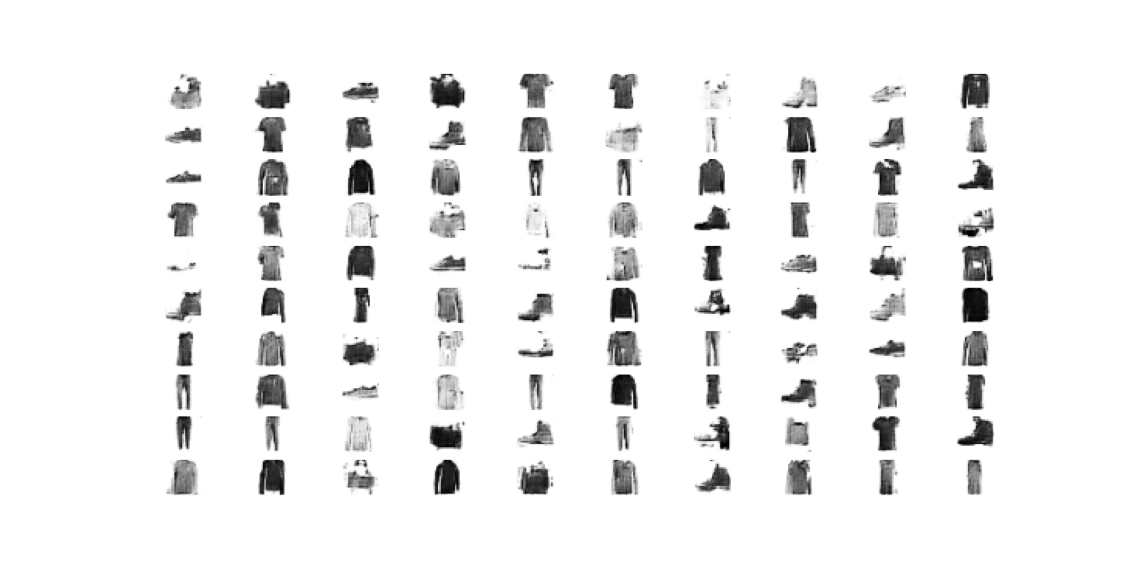

In [15]:
PATH = '/kaggle/working/'


plt.figure(figsize=(20,15))
plt.axis('off')

plt.imshow(plt.imread(PATH +'generated_plot_e010.png'))

### 2. After 30 EPOCHS

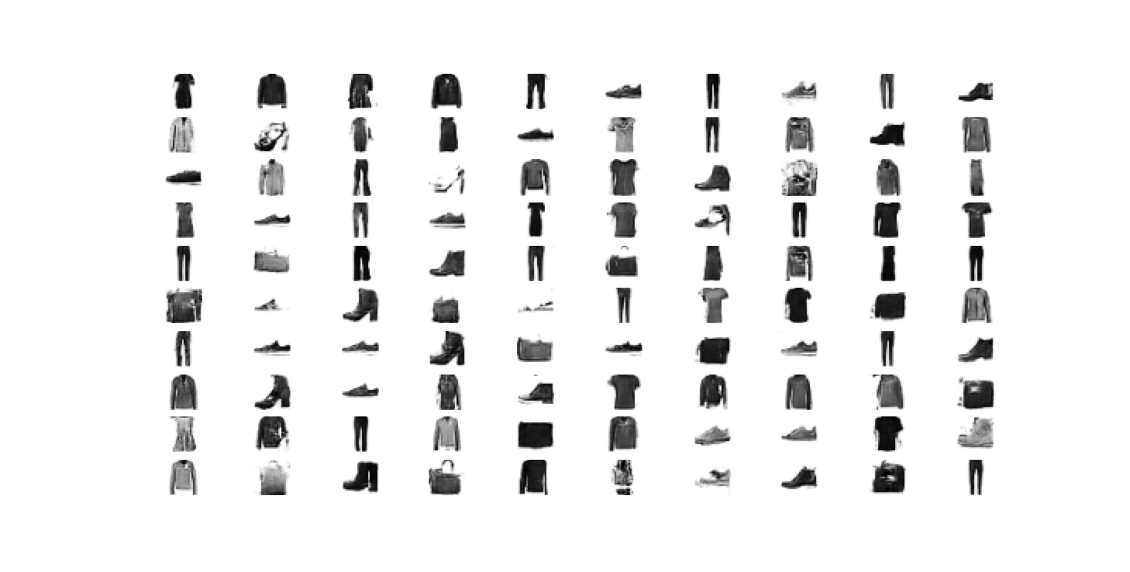

In [16]:
plt.figure(figsize=(20,15))
plt.axis('off')

plt.imshow(plt.imread(PATH +'generated_plot_e030.png'))

#### 3. After 100 EPOCHS

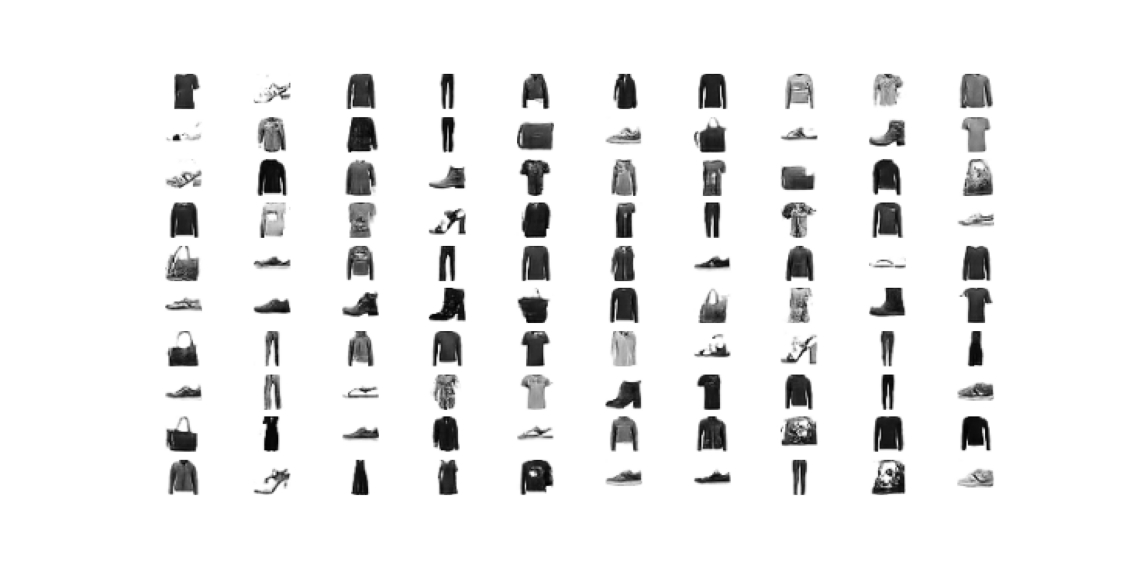

In [18]:
PATH = '/kaggle/working/'

plt.figure(figsize=(20,15))
plt.axis('off')

plt.imshow(plt.imread(PATH +'generated_plot_e100.png'))

## Conditional Clothing Generation

In [19]:
def show_plot(examples, n=10):
  # plot images
    plt.figure(figsize=(30,20))
    for i in range(n * n):
        # define subplot
        plt.subplot(n, n, 1 + i)
        # turn off axis
        plt.axis('off')
        # plot raw pixel data
        plt.imshow(examples[i], cmap='gray_r')
    plt.show()

In [21]:
np.asarray([x for _ in range(10) for x in range(10)])

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1,
       2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3,
       4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5,
       6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7,
       8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

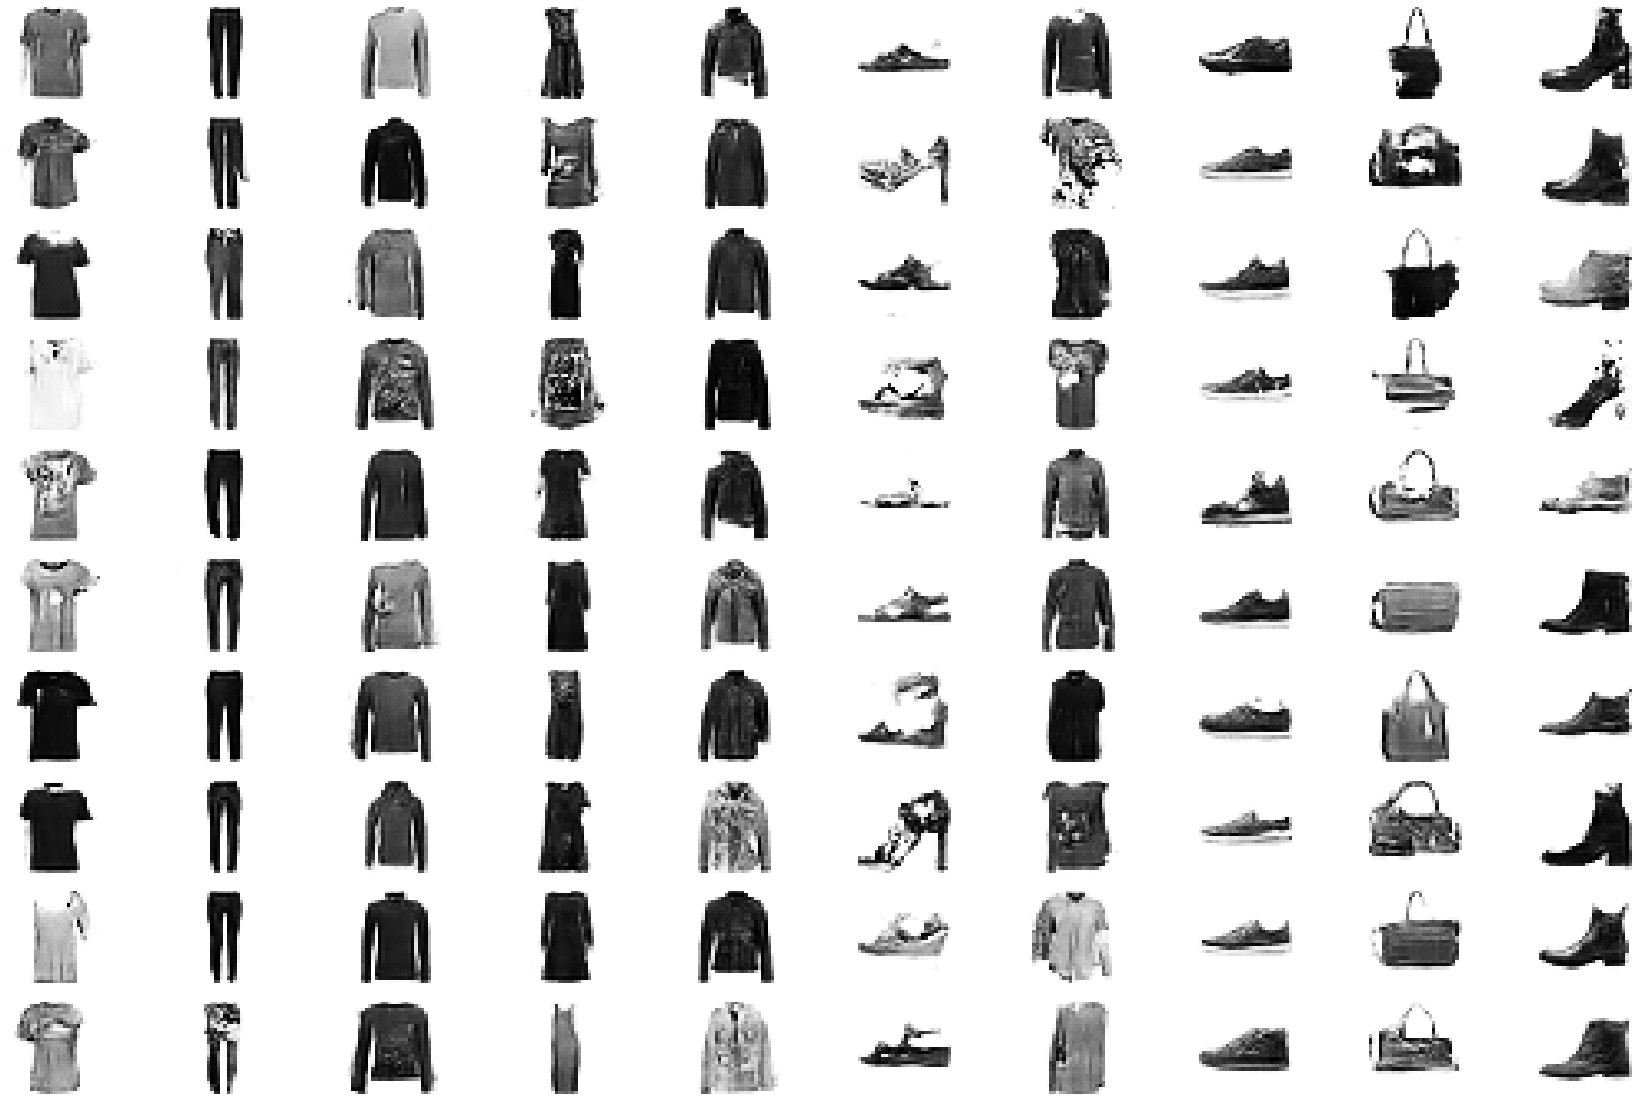

In [22]:
latent_points, labels = generate_latent_points(100, 100)

labels = np.asarray([x for _ in range(10) for x in range(10)])

model = load_model(PATH + 'generator_model_100.h5')

X = model.predict([latent_points, labels])


# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0

# plot the result
show_plot(X, 10)

<h3>Full Sleeve Tshirt</h3>

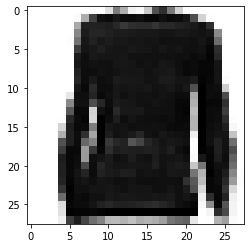

In [23]:
latent_points, labels = generate_latent_points(100, 1)
label = np.asarray([2])

X = model.predict([latent_points, label])


# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0

# plot the result
plt.imshow(X[0], cmap='gray_r')

### Purse

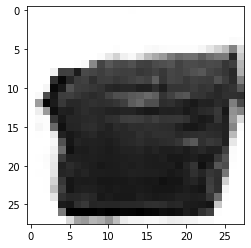

In [24]:
latent_points, labels = generate_latent_points(100, 1)

label = np.asarray([8])

X = model.predict([latent_points, label])


# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0

# plot the result
plt.imshow(X[0], cmap='gray_r')

<h3>Shoes</h3>

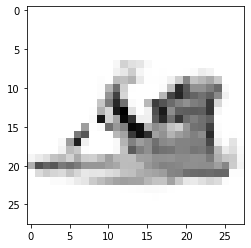

In [25]:
latent_points, labels = generate_latent_points(100, 1)

label = np.asarray([5])

X = model.predict([latent_points, label])


# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0

# plot the result
plt.imshow(X[0], cmap='gray_r')